# Part 3: Propose the Research Study

<br>

<div align="center">
    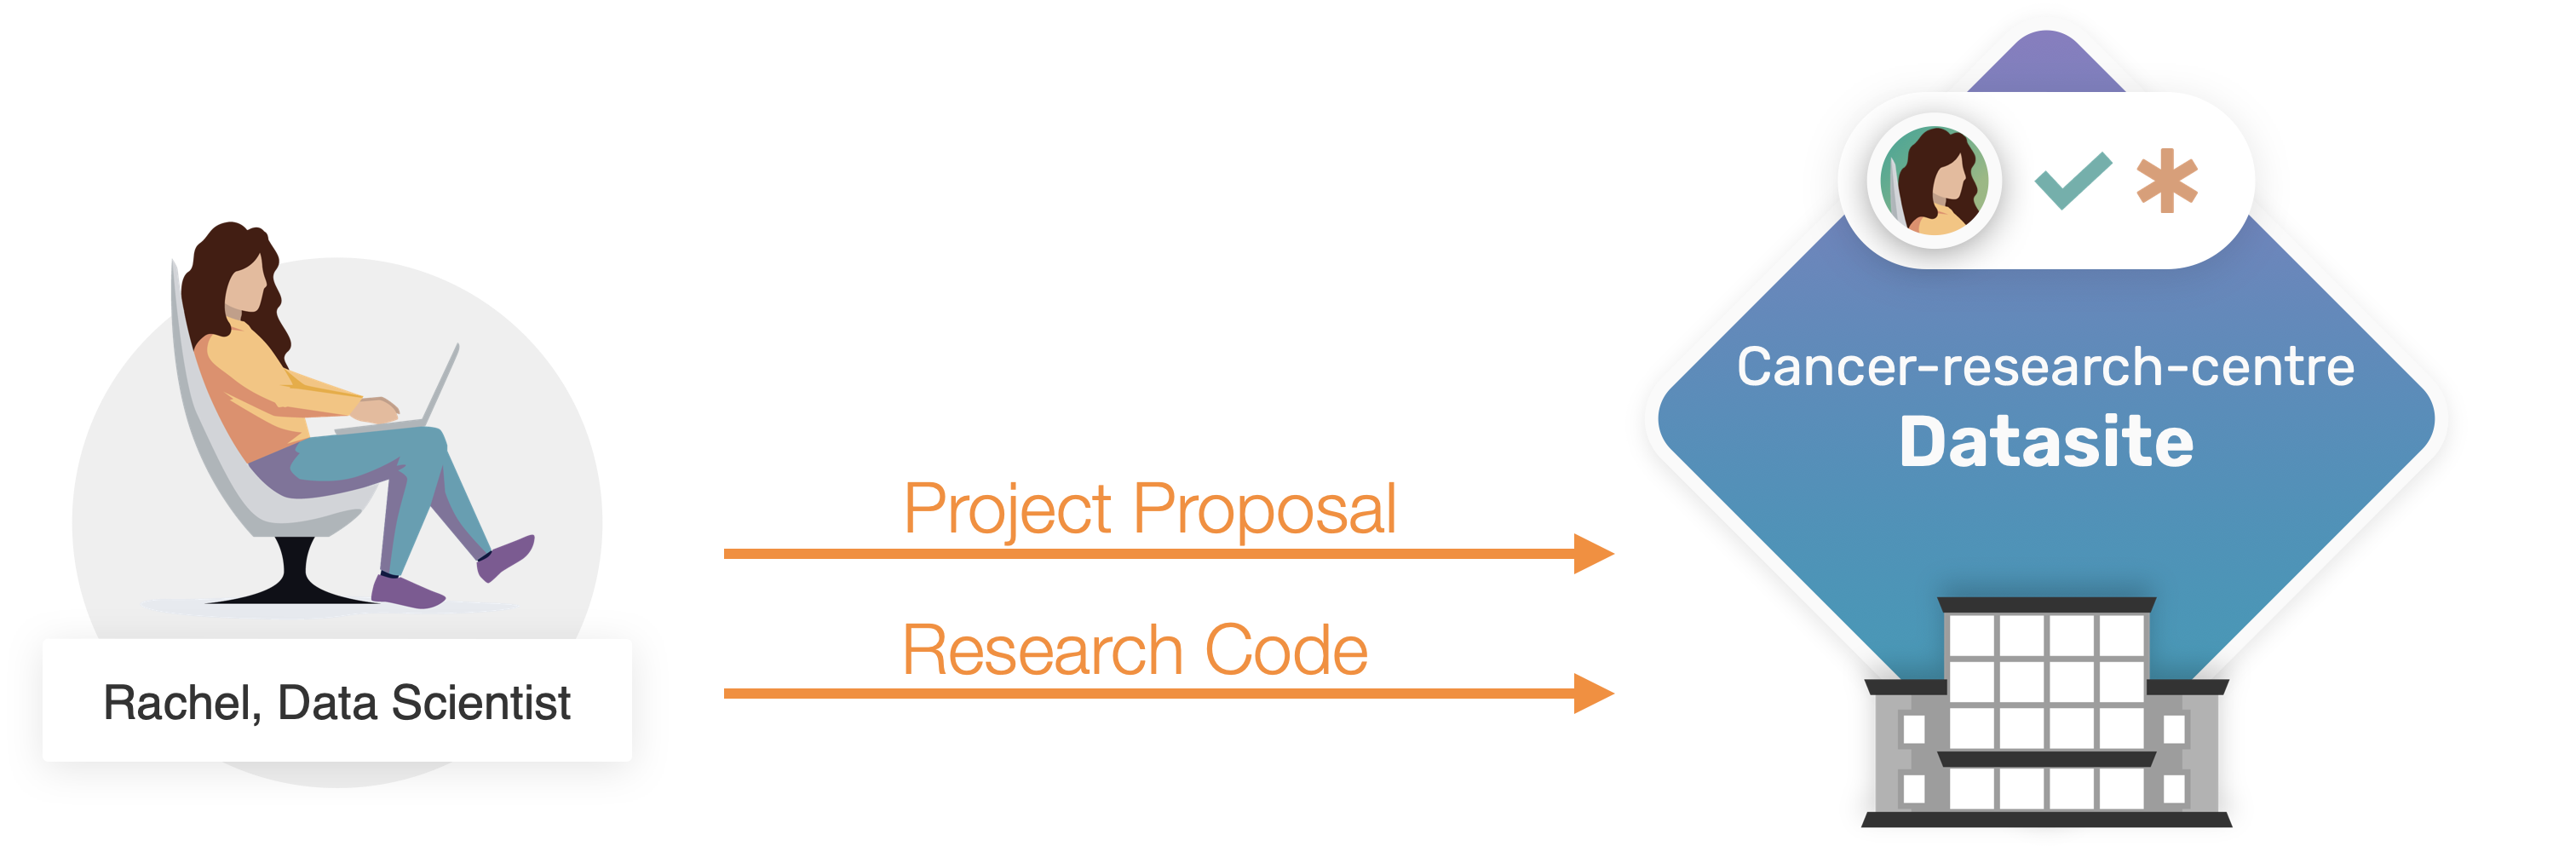
</div>

<br>

In [**part 1**](part1-dataset-and-assets.ipynb) and [**part 2**](part2-datasite-access.ipynb) we have learnt PySyft features entirely from the perspective of the Data Owner.

> Owen, as per their own duties of Laboratory Manager, and PySyft _Data Owner_, set up the Datasite by creating and uploading the "Breast Cancer Biomarker" dataset; and by creating Rachel's credentials for remote access.

We will now explore how Rachel would be able to interact with a Datasite as a data scientist, and how PySyft guarantees that non-public information would never be seen nor opened by external users.

The workflow for doing remote data science with PySyft on a private dataset consists of three parts:
- (1) **preparing the research project**: this is the most thorough part, and this will be the focus of **this part**; the data scientist is involved at every step here.
- (2) **computation on real data**: the code embedded in the research project is run using the private data as input, to compute the real result (see [**part 4**](part4-review-code-request.ipynb))
- (3) **result approval and release**: the real result is inspected to ensure that it satisfies the privacy policy of the dataset; if all is fine, then the real result is sent back to the data scientist (see [**part 5**](part5-retrieving-results.ipynb))

The first step to carry out research on non-public data using PySyft is to prepare a **research project submission**. 

## What you will learn

By the end of **part 3**, you will learn:

- How to access a Datasite as a Data Scientist, and explore available datasets;
- How to use mock data to prepare the data analysis code;
- How to create a PySyft _Remote Code Request_;
- How to create and submit a Project proposal to a Datasite.


## |:data_owner:| 3.1. Log into the Datasite

<br>

<div align="center">
    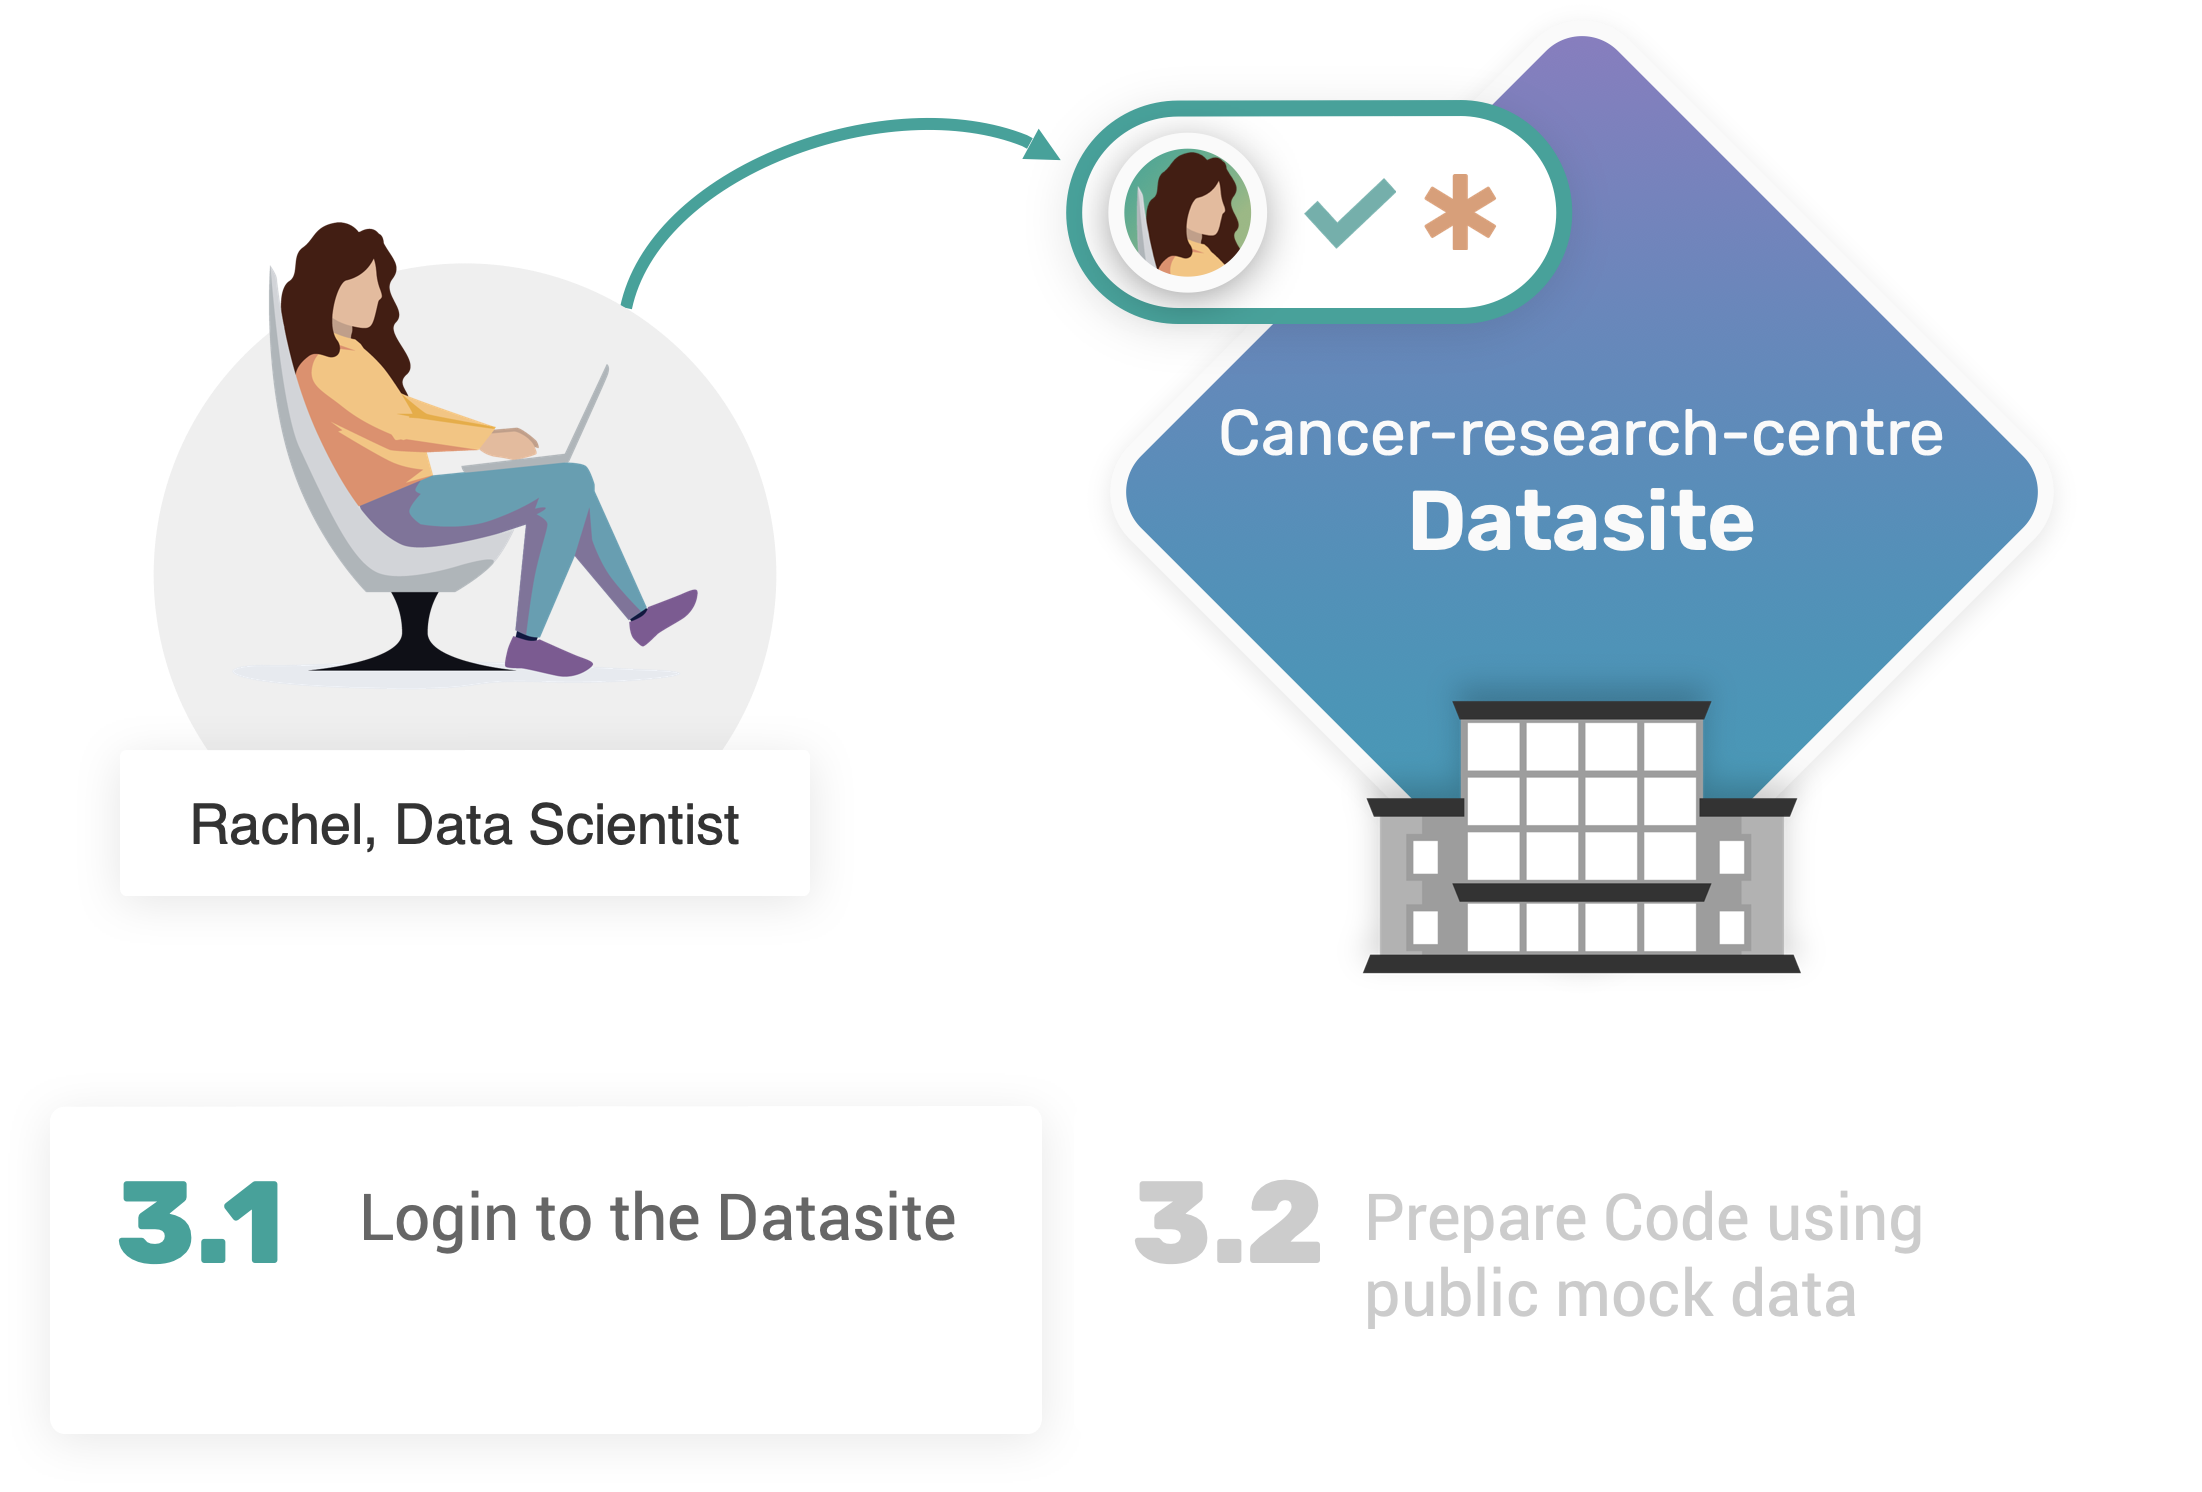
</div>

<br>

First, let's make sure that the _local development Datasite_ is running. If not, `syft.orchestra.launch` will bootstrap the server instance once again. 

In [1]:
import syft as sy

data_site = sy.orchestra.launch(name="cancer-research-centre")

SyftInfo: You have launched a development server at http://0.0.0.0:None.It is intended only for local use.

Now it is time for Rachel to login to the Datasite using their newly received credentials sent by Owen separately:

In [2]:
client = data_site.login(email="rachel@datascience.inst", password="syftrocks")

Logged into <cancer-research-centre: High side Datasite> as <rachel@datascience.inst>


On logging into the domain, Rachel, as data scientist, can explore the datasets available in the Datasite. We can easily do so by accessing `client.datasets` 

In [3]:
client.datasets

As expected, the Datasite contains one dataset, named `Breast Cancer Biomarker`, which includes 2 assets.

Once identified the dataset we are interested in, we can access them either by `index` or by their unique `name`:

In [4]:
bc_dataset = client.datasets["Breast Cancer Biomarker"]

We obtained `bc_dataset` that is a pointer to a _remote_ dataset.

In [5]:
bc_dataset

syft.service.dataset.dataset.Dataset

Using a pointer to a remote dataset, we can access its internal assets either by `index` or by their unique names.
In our example, we can create a pointer to the _features_ asset, and the _targets_ asset:

In [6]:
features, targets = bc_dataset.assets  # using Python tuple unpacking

Let's now validate the assumptions that **only** `mock` data is accessible to a data scientist, and that `data` is **not**. We will do so by using the two `features` and `targets` variables, that are indeed pointers to their corresponding remote assets.

```{admonition} Remmeber
In part 1, the two assets were created and stored as <code>pandas.DataFrame</code> objects.
```

In [7]:
features.mock.head(n=3)  # pandas.DataFrame

radius1   texture1  perimeter1        area1  smoothness1  compactness1  \
0  33.046908  29.731572  215.098990  1656.558336     0.247296      0.895168   
1  35.013667  37.934637  225.663466  1981.439696     1.118171      0.221639   
2  34.001211  40.764501  222.546536  1858.657787     0.267806      0.563065   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...    radius3  \
0    1.265891         0.790790   0.764319            0.548207  ...  42.197438   
1    0.219281         0.627345   0.962795            1.038450  ...  41.954626   
2    1.145187         1.005505   0.669716            0.322992  ...  39.921702   

    texture3  perimeter3        area3  smoothness3  compactness3  concavity3  \
0  43.739306  292.853545  2900.213334     1.038016      1.677809    1.376853   
1  49.526826  266.967840  2837.546722     0.374848      0.552945    1.238547   
2  51.652774  259.925892  2590.168154     0.880825      1.050142    1.011544   

   concave_points3  symmetry3  fractal_dimension3  
0         0.961337   1.523891            0.756000  
1         0.332209   0.719879            0.187481  
2         0.496103   1.242959            1.003488  

[3 rows x 30 columns]

Let's try to do the same with `targets`:

In [8]:
targets.mock.head(n=3)

Diagnosis
0         B
1         B
2         B

**Brilliant!** And what about `data`? 🧐

In [9]:
features.data

SyftError: You do not have permission to access private data.

In [10]:
targets.data

SyftError: You do not have permission to access private data.

As expected, Rachel, as a data scientist, does **not** have **read permissions** (_nor any other permissions_, ed.) on the non-public information stored in the remote asset.

This clear distinction between the main components of an asset has the following advantages:

1. mock data is open-access and imposes no risks to the data owner for sharing publicly non-public information;
2. it creates a staging environment for the data scientist to simulate their intended study in a realistic way;
3. reduces liability for the data scientist, who is not responsible anymore for storing safely non-public data;
4. enables the data owner to control how non-public assets can be used by data scientists for their study.


## |:data_owner:| 3.2. Prepare code using mock data

<br>

<div align="center">
    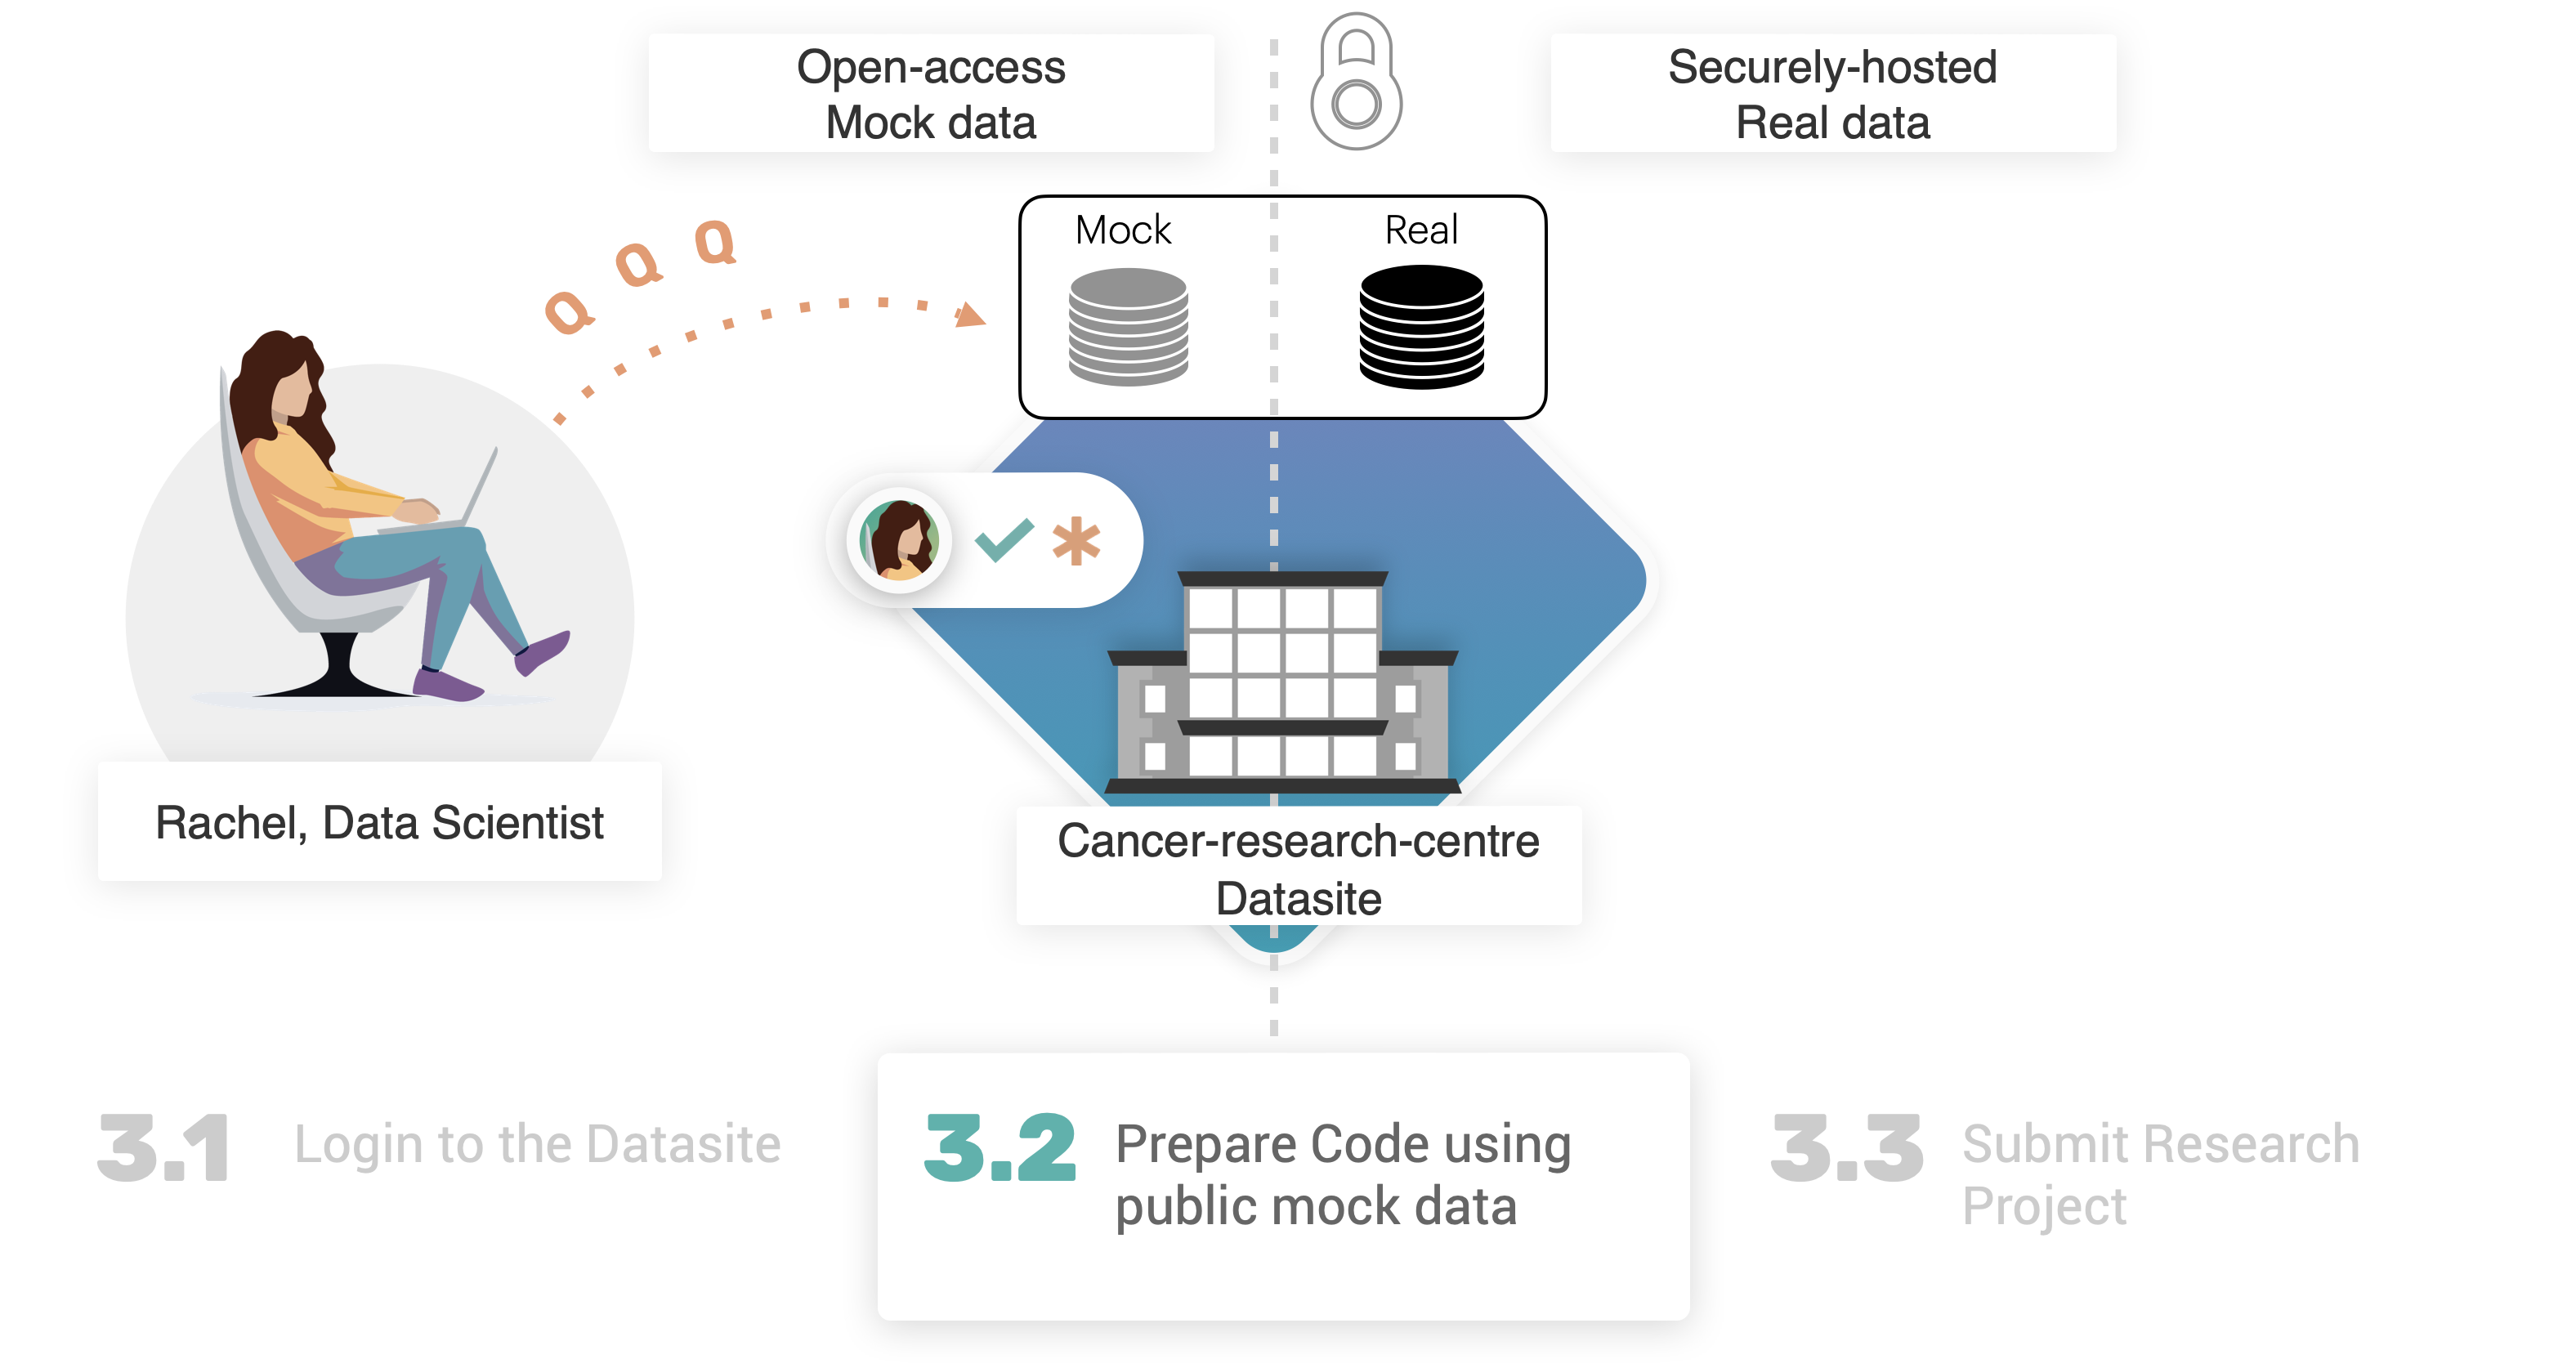
</div>

<br>
Getting access to the mock data allows to get a general understanding of what non-public data would look like. So we can use this data to start preparing our code, to run on this data.

Rachel decides to study the breast cancer data by running a simple supervised machine learning experiment using the [scikit-learn](https://scikit-learn.org) library.
The dataset is represented as `pandas.DataFrame`, and _features_ are already in the format expected by machine learning models: `samples x features` matrix. 
This conclusion has been derived by looking at the _mock_ data, and therefore we can assume it is similarly applicable to the true _real_ data.

In [11]:
X, y = features.mock, targets.mock

In short, these are steps of the machine learning experiment that Rachel has in mind:

1. use the `train_test_split` function to generate _training_ and _testing_ partitions;
3. apply `StandardScaler` to normalise features;
4. train a `LogisticRegression` model;
5. calculate `accuracy_score` on training, and testing data.

For simplicity, let's wrap the whole pipeline into a [**single Python function**](../components/code-api.ipynb#what-is-a-syft-function). In this way it will be easier to prepare our code request to send to PySyft for execution.

In [12]:
def ml_experiment_on_breast_cancer_data(features_data, labels, seed: int = 12345) -> tuple[float, float]:
    # include the necessary imports in the main body of the function
    # to prepare for what PySyft would expect for submitted code.
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    
    X, y = features_data, labels.values.ravel()
    # 1. Data Partition
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)
    # 2. Data normalisation
    scaler = StandardScaler()
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # 3. Model training
    model = LogisticRegression().fit(X_train, y_train)
    # 4. Metrics Calculation
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))
    
    return acc_train, acc_test

Let's call the function on the mock data, to check that everything works:

In [13]:
ml_experiment_on_breast_cancer_data(features_data=features.mock, labels=targets.mock)

(0.6737089201877934, 0.5874125874125874)

## |:data_owner:| 3.3. Submit a Research Project

Now that our code has been tested locally, we are ready to proceed to prepare our code for **remote execution**, and then create a new **research project** to submit to the Datasite. 

<br>

<div align="center">
    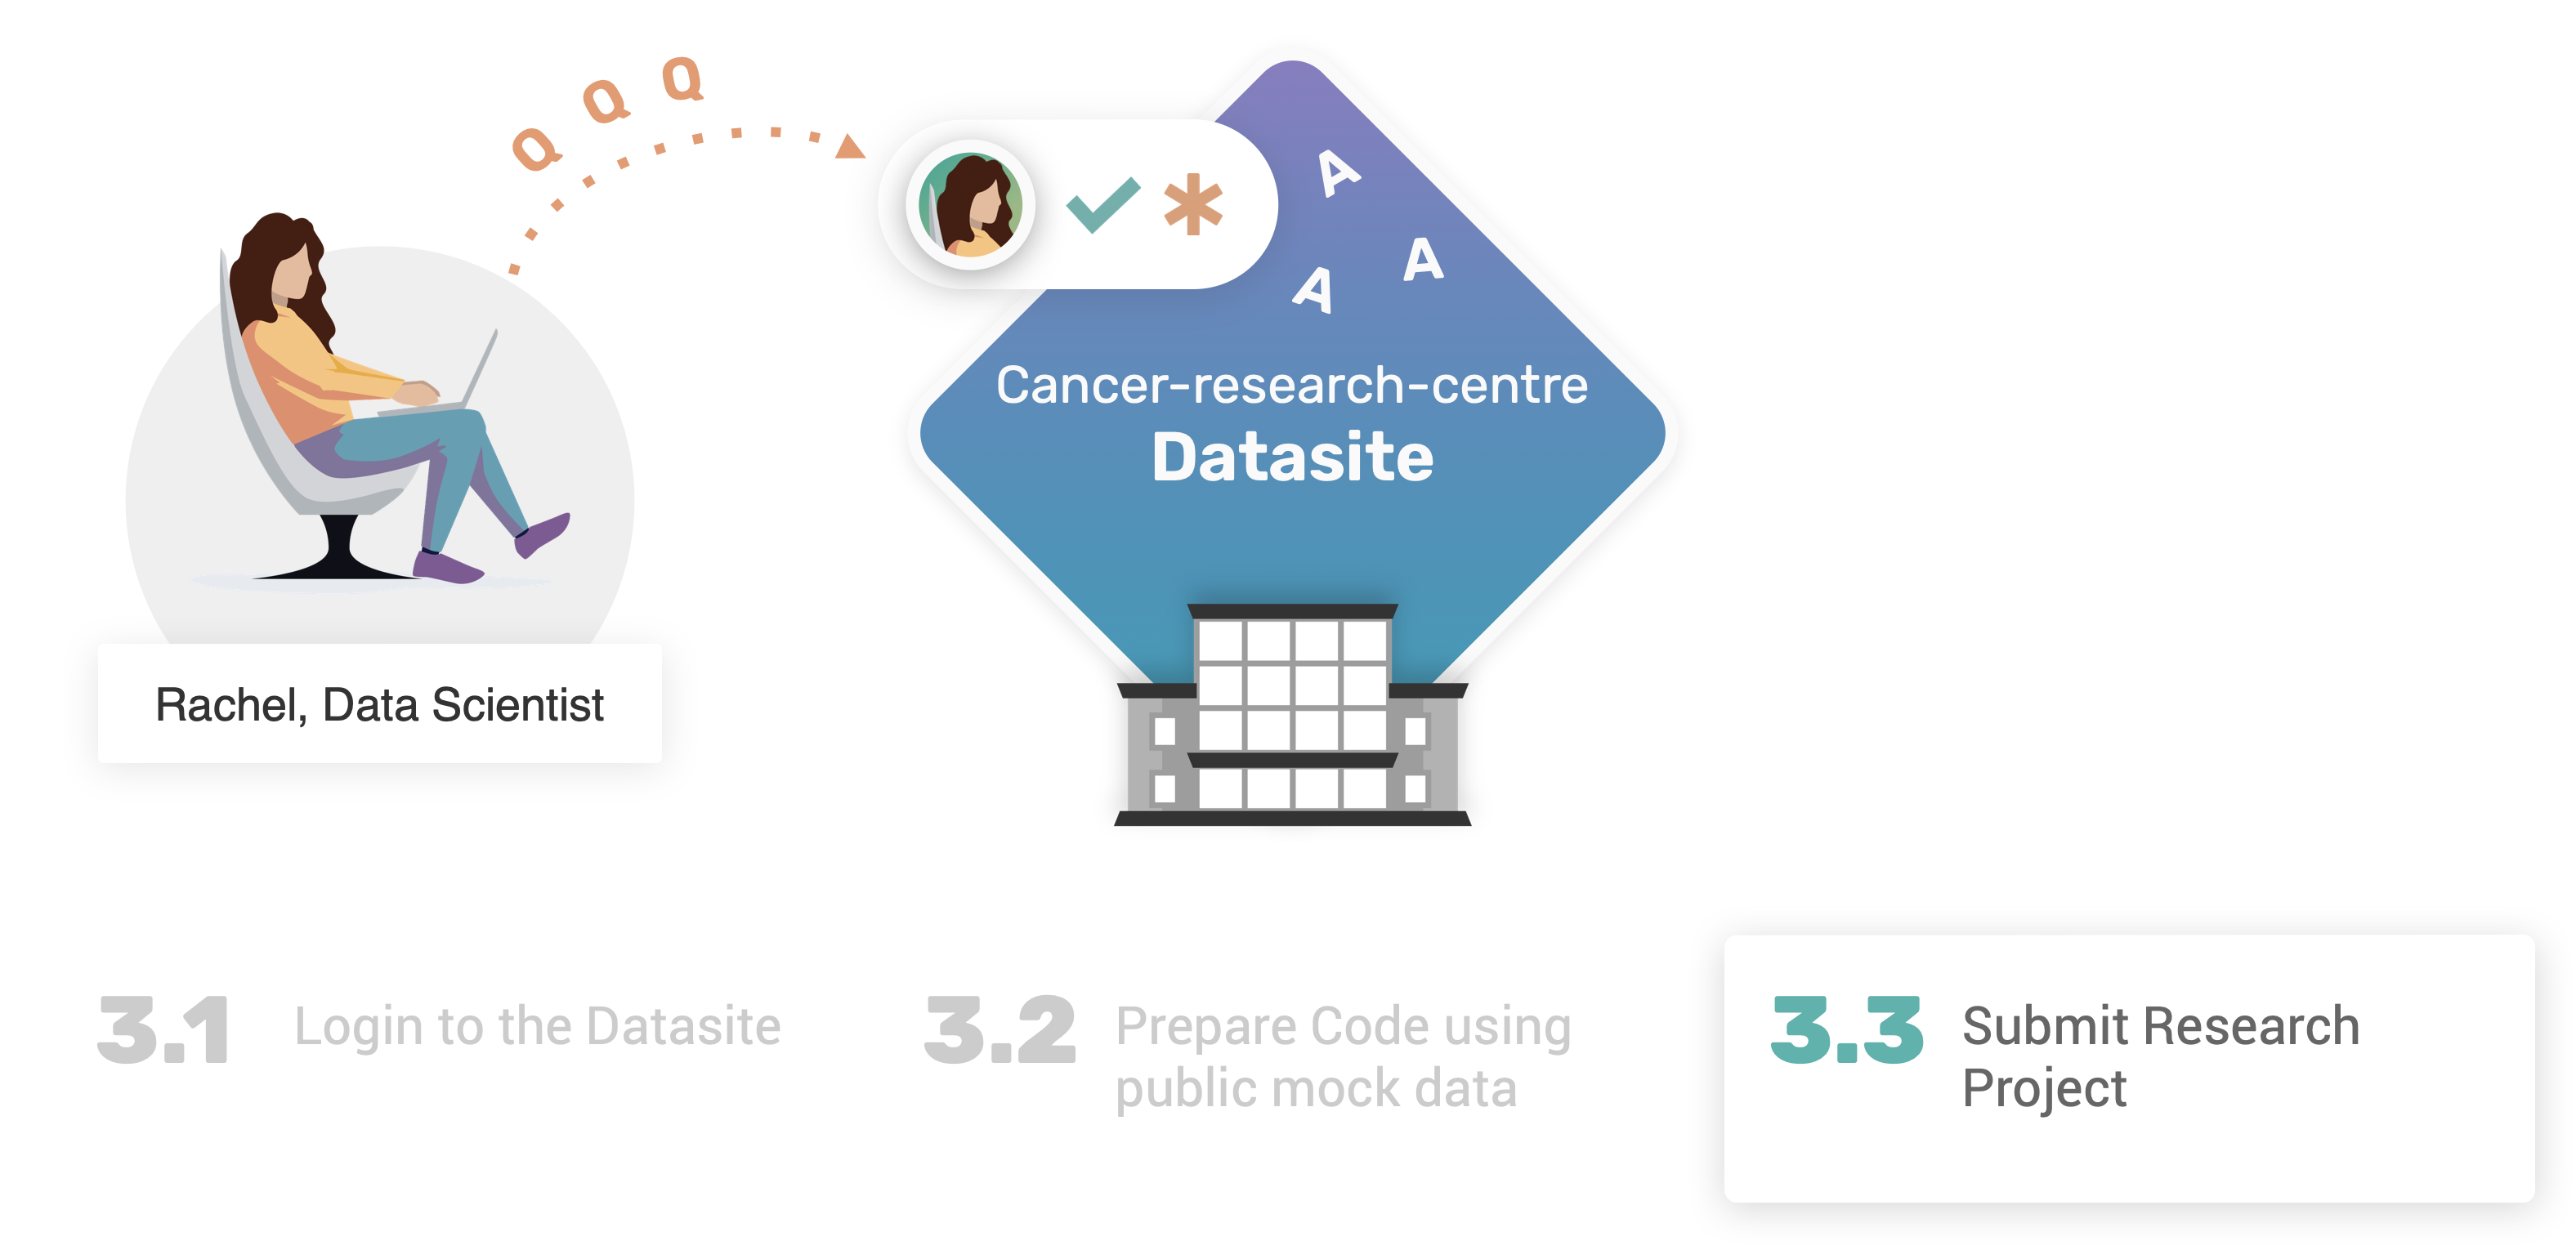
</div>

<br>

In the previous section, we have verified that our `ml_experiment_on_breast_cancer_data` could run with sucess locally on the mock data. Now, we would be interested in testing that function on _real_ data, using PySyft. In prticular, we need to convert the _transform_ our (local) Python function into a _remote code request_: a function that PySyft can process, and execute remotely on the Datasite, where _real_ data are stored.

To do so, we only need to wrap our Python function with a special decorator: [`syft_function_single_use`](../components/code-api.ipynb#what-is-a-syft-function).

In [14]:
remote_user_code = sy.syft_function_single_use(features_data=features, labels=targets)(ml_experiment_on_breast_cancer_data)

SyftSuccess: Syft function 'ml_experiment_on_breast_cancer_data' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

```{admonition} *syft_function_single_use* decorator
The <code>syft_function_single_use</code> decorator is a simple shortcut over a more generic <code>syft_function</code> decorator. This decorator expects two main parameters, namely <code>input_policy</code>, and <code>output_policy</code>. The former provides to data owner the confidence that the submitted code will only run on the selected input assets; the latter is used to maintain status across multiple executions, e.g. imposing an upper limit to the number of times a specified code is allowed to run.

Please check out the [Syft Policy Component](../components/syft-policies.ipynb) for further details.
```

At this point, we _may_ go ahead and submit our `remote_user_code` request. However, this would make things extremely difficult for Owen, as they would have no clue whatsoever about the intent of the code, nor of the study Rachel is willing to conduct on the "Cancer Research Centre" data! 

To overcome these issues, PySyft allows to create and submit a _research project_! In essence, [a Project (i.e. `syft.Project`)](../components/projects-api.ipynb) is composed by one (or more) **code request**(s), and includes a (short) description to communicate the intent of the study to the data owner. 

<br>

<div align="center">
   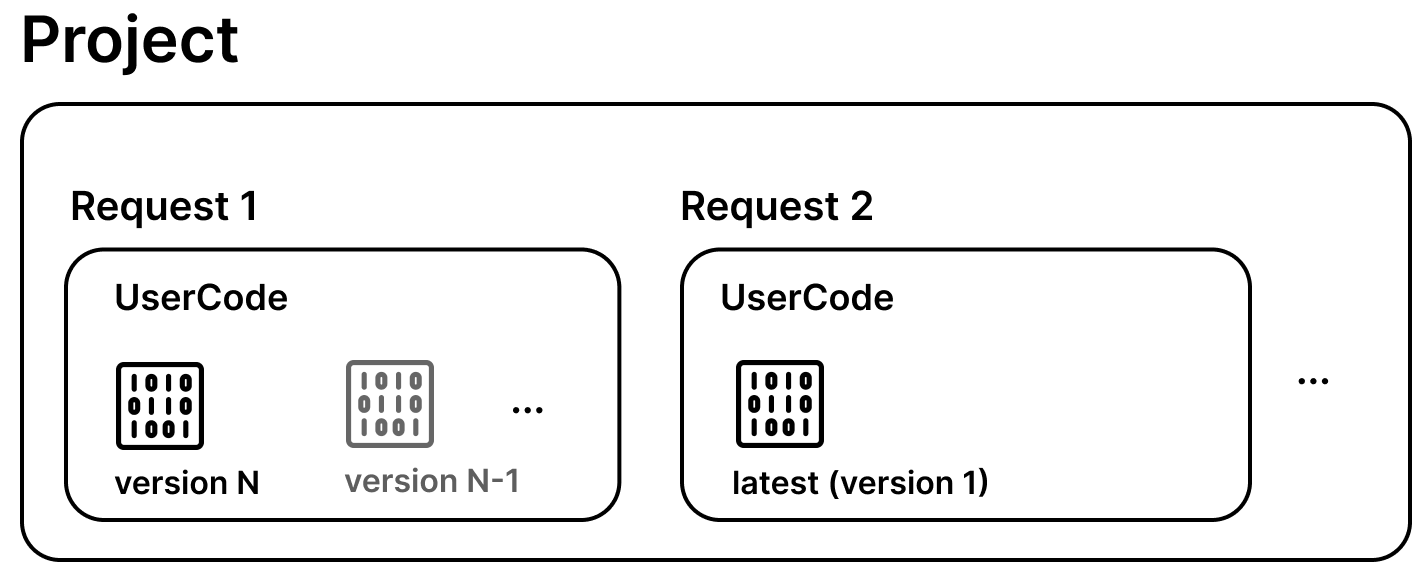
</div>

<br>

In [15]:
description = """
    The purpose of this study will be to run a machine learning
    experimental pipeline on breast cancer data. 
    As first attempt, the pipelines includes a normalisation steps for 
    features and labels using a StandardScaler and a LabelEncoder. 
    The selected ML model is Logistic regression, with the intent
    to gather the accuracy scores on both training, and testing 
    data partitions, randomly generated.
"""

# Create a project

research_project = client.create_project(
    name="Breast Cancer ML Project",
    description=description,
    user_email_address="rachel@datascience.inst"
)

We can access to the list of available `projects` through our `client`:

In [16]:
client.projects

```{admonition} Unique project names

Projects are identified by their <b>unique</b> name. This means that duplicate submissions will lead to an error in PySyft.
```

We can use the `create_code_request` method to attach our new code request to our `syft.Project` instance, i.e. `research_project` 

In [17]:
code_request = research_project.create_code_request(remote_user_code, client)

In [18]:
code_request

SyftSuccess: Code request for 'ml_experiment_on_breast_cancer_data' successfully added to 'Breast Cancer ML Project' Project. To see code requests by a client, run `[your_client].code`

We can now check that the code request has reached the project by accessing `client.code`:

In [19]:
client.code

We do indeed have a code request, in `PENDING` status. Similarly, we can review our existing requests, by accessing `client.requests`:

In [20]:
client.requests

More about [user codes](../components/code-api.ipynb) and [requests](../components/requests-api.ipynb) is available in the components section.

### Before moving on

Let's say Rachel is very impatient, and would try to force the execution of a _not-yet-approved_ (_not-yet-reviewed_) request. Let's see what PySyft allows:

In [21]:
client.code.ml_experiment_on_breast_cancer_data(features_data=features, labels=targets)

SyftError: <class 'syft.service.code.user_code.UserCodeStatusCollection'> Your code is waiting for approval. Code status on server 'cancer-research-centre' is 'UserCodeStatus.PENDING'.

As expected, if we try to execute a code request that has not yet been approved, a **SyftError** is returned!

## Congrats on completing Part 3 🎉

Well done for completing **part 3** of the tutorial! 👏 

Now Rachel has prepared and finalised their research project, that has been sent to Owen for review. 
This project included the machine learning pipeline Rachel prepared and tested on mock data, and that has been attached to the project for remote execution on the _real_ data. 

In the [**part 4**](./part4-review-code-request.ipynb), we will explore how the code request revision process works in PySyft, switching again the perspective to the one of the data owner who needs to review, and in case, appove, the requests.